# YOLOv8 Cocoa Bean Quality Classification

Training a YOLOv8 classification model to distinguish between good quality ('sana') and poor quality ('mala') cocoa beans.

## 1. Setup and Installation

In [1]:
!pip install ultralytics
!pip install opencv-python
!pip install pillow
!pip install matplotlib

In [2]:
from ultralytics import YOLO
import os
from pathlib import Path
import shutil
import yaml
import matplotlib.pyplot as plt
from PIL import Image

## 2. Mount Google Drive

**If mount fails:**
1. Runtime → Disconnect and delete runtime
2. Runtime → Restart runtime
3. Clear browser cache/cookies
4. Try incognito mode
5. Re-run this cell

In [3]:
from google.colab import drive

try:
    drive.mount('/content/drive', force_remount=True)
    print("✓ Drive mounted successfully!")
except Exception as e:
    print(f"✗ Mount failed: {str(e)}")
    print("\nFollow the troubleshooting steps above")
    raise

Mounted at /content/drive
✓ Drive mounted successfully!


## 3. Verify Dataset Structure

In [4]:
data_config = {
    'path': '/content/drive/MyDrive/Cacao_dataset_kaggle/dataset_original_train_val',
    'train': 'train',
    'val': 'val',
    'names': ['mala', 'sana']
}

dataset_path = Path(data_config['path'])
train_path = dataset_path / data_config['train']
val_path = dataset_path / data_config['val']

print(f"Dataset path exists: {dataset_path.exists()}")
print(f"Train path exists: {train_path.exists()}")
print(f"Val path exists: {val_path.exists()}")

Dataset path exists: True
Train path exists: True
Val path exists: True


In [5]:
# Count images per class in train set
for class_name in data_config['names']:
    class_path = train_path / class_name
    if class_path.exists():
        num_images = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
        print(f"Train - {class_name}: {num_images} images")

# Count images per class in val set
for class_name in data_config['names']:
    class_path = val_path / class_name
    if class_path.exists():
        num_images = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
        print(f"Val - {class_name}: {num_images} images")

Train - mala: 300 images
Train - sana: 1000 images
Val - mala: 73 images
Val - sana: 261 images


## 4. Visualize Sample Images

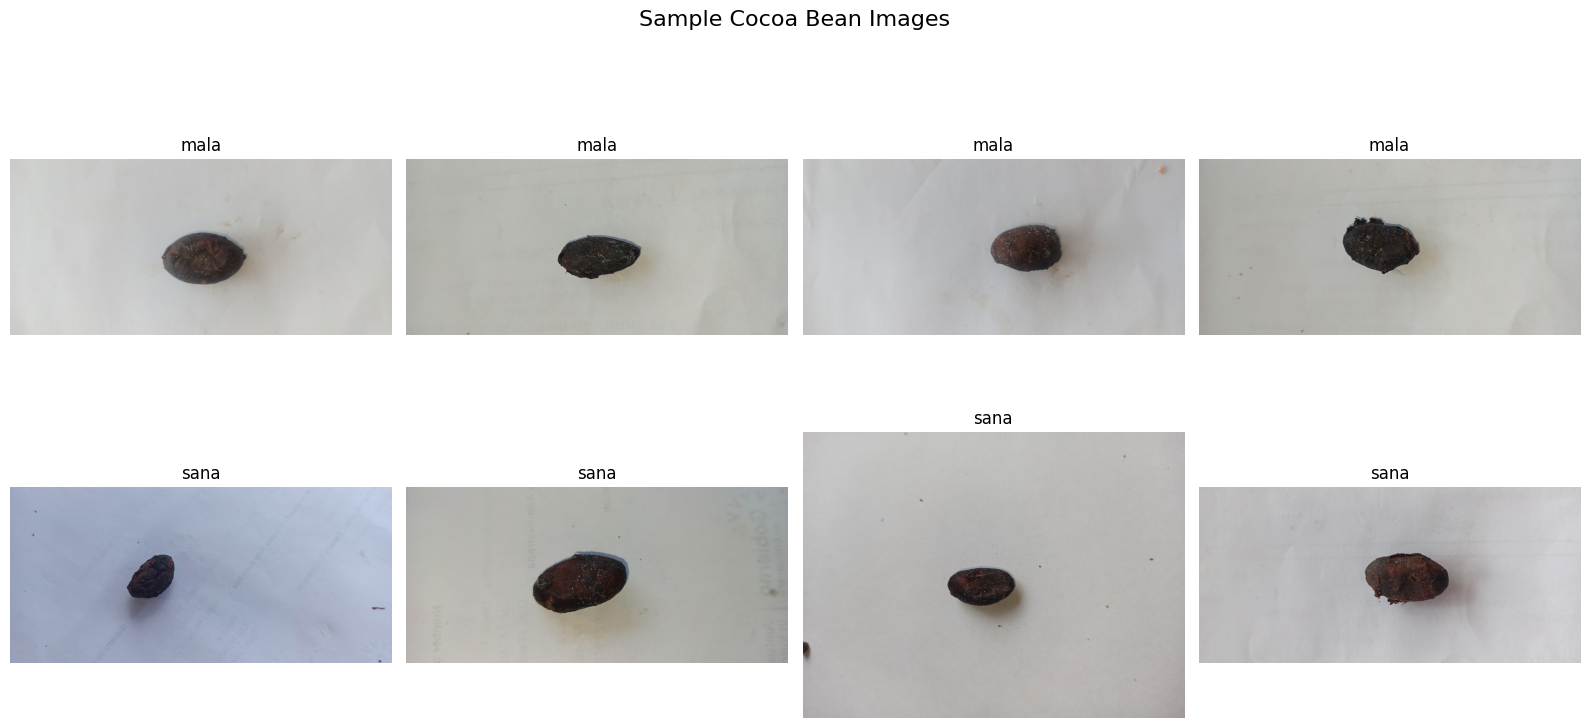

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Cocoa Bean Images', fontsize=16)

for idx, class_name in enumerate(data_config['names']):
    class_path = train_path / class_name
    images = list(class_path.glob('*.jpg'))[:4]

    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[idx, i].imshow(img)
        axes[idx, i].set_title(f'{class_name}')
        axes[idx, i].axis('off')

plt.tight_layout()
plt.show()

## 5. Create YAML Configuration for YOLOv8

In [7]:
yaml_config = {
    'path': str(dataset_path),
    'train': data_config['train'],
    'val': data_config['val'],
    'names': {i: name for i, name in enumerate(data_config['names'])}
}

yaml_path = '/content/cocoa_dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_config, f, default_flow_style=False)

print(f"YAML config saved to {yaml_path}")
print("\nConfig contents:")
with open(yaml_path, 'r') as f:
    print(f.read())

YAML config saved to /content/cocoa_dataset.yaml

Config contents:
names:
  0: mala
  1: sana
path: /content/drive/MyDrive/Cacao_dataset_kaggle/dataset_original_train_val
train: train
val: val



## 6. Initialize YOLOv8 Classification Model

In [8]:
# Load a pretrained YOLOv8 classification model
# Options: yolov8n-cls.pt (nano), yolov8s-cls.pt (small), yolov8m-cls.pt (medium)
model = YOLO('yolov8n-cls.pt')
print("Model loaded successfully")

Model loaded successfully


## 7. Train the Model

In [11]:
# Training configuration
results = model.train(
    data=dataset_path, # Changed from yaml_path to dataset_path
    epochs=50,
    imgsz=224,
    batch=32,
    patience=10,
    save=True,
    device=0,  # Use GPU 0, set to 'cpu' if no GPU available
    project='cocoa_classification',
    name='yolov8n_run1',
    exist_ok=True,
    pretrained=True,
    optimizer='Adam',
    verbose=True,
    seed=42,
    deterministic=True,
    val=True
)

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Cacao_dataset_kaggle/dataset_original_train_val, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8n_run1, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask

KeyboardInterrupt: 

## 8. Evaluate Model Performance

In [ ]:
# Validate the model
metrics = model.val()

print(f"\nValidation Results:")
print(f"Top-1 Accuracy: {metrics.top1:.4f}")
print(f"Top-5 Accuracy: {metrics.top5:.4f}")

## 9. Visualize Training Results

In [ ]:
# Display training curves
results_path = Path('cocoa_classification/yolov8n_run1')

if (results_path / 'results.png').exists():
    img = Image.open(results_path / 'results.png')
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Results')
    plt.show()
else:
    print("Results plot not found")

In [ ]:
# Display confusion matrix
if (results_path / 'confusion_matrix_normalized.png').exists():
    img = Image.open(results_path / 'confusion_matrix_normalized.png')
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Normalized Confusion Matrix')
    plt.show()
else:
    print("Confusion matrix not found")

## 10. Test on Sample Images

In [ ]:
# Load the best model
best_model = YOLO('cocoa_classification/yolov8n_run1/weights/best.pt')

# Get sample test images
test_images = []
for class_name in data_config['names']:
    class_path = val_path / class_name
    test_images.extend(list(class_path.glob('*.jpg'))[:3])

# Run predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_path in enumerate(test_images[:6]):
    img = Image.open(img_path)
    results = best_model(img_path)

    # Get prediction
    probs = results[0].probs
    pred_class = data_config['names'][probs.top1]
    confidence = probs.top1conf.item()
    true_class = img_path.parent.name

    axes[idx].imshow(img)
    axes[idx].set_title(f'True: {true_class}\nPred: {pred_class} ({confidence:.2%})')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 11. Export Model

In [ ]:
# Export to different formats
best_model.export(format='onnx')  # ONNX format
best_model.export(format='torchscript')  # TorchScript format

print("Model exported successfully")
print(f"Model location: cocoa_classification/yolov8n_run1/weights/")

## 12. Save Model to Google Drive

In [ ]:
# Create directory in Google Drive for models
drive_model_path = Path('/content/drive/MyDrive/cocoa_models')
drive_model_path.mkdir(exist_ok=True)

# Copy best weights
shutil.copy(
    'cocoa_classification/yolov8n_run1/weights/best.pt',
    drive_model_path / 'yolov8n_cocoa_best.pt'
)

# Copy results
if (results_path / 'results.csv').exists():
    shutil.copy(
        results_path / 'results.csv',
        drive_model_path / 'training_results.csv'
    )

print(f"Model and results saved to {drive_model_path}")

## 13. Model Summary and Next Steps

In [ ]:
print("=" * 60)
print("Training Complete!")
print("=" * 60)
print(f"\nModel: YOLOv8n Classification")
print(f"Classes: {data_config['names']}")
print(f"Top-1 Accuracy: {metrics.top1:.4f}")
print(f"\nModel saved to: cocoa_classification/yolov8n_run1/weights/best.pt")
print(f"Backed up to: {drive_model_path}")
print("\nNext Steps:")
print("1. Review confusion matrix for misclassifications")
print("2. Consider data augmentation if needed")
print("3. Try larger models (yolov8s-cls, yolov8m-cls) for better accuracy")
print("4. Implement the model in your application")
print("=" * 60)